In [1]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [2]:
# Import các thư viện cần thiết

# import model và các thư viện liên quan training
from keras.preprocessing.image import  ImageDataGenerator,load_img
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# xử lí tệp
import zipfile
import os
from google.colab import drive

# xử lí toán học
import pandas as pd
import numpy as np
import cv2

# biểu đồ
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


kết nối với ggDrive

In [3]:
# Kết nối Google Drive
drive.mount('/content/drive')

# Đường dẫn đến thư mục chứa các file zip
zip_train_path = '/content/drive/MyDrive/TrainingDogCatData/train.zip'
zip_test_path = '/content/drive/MyDrive/TrainingDogCatData/test.zip'

# Giải nén các file zip
with zipfile.ZipFile(zip_train_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train')

with zipfile.ZipFile(zip_test_path, 'r') as zip_ref:
    zip_ref.extractall('/content/test')

# Đường dẫn đến các thư mục sau khi giải nén
train_dir = '/content/train/train'
test_dir = '/content/test/test1'


Mounted at /content/drive


In [13]:
# Tạo danh sách chứa tên tệp và nhãn của từng tệp (0 cho mèo, 1 cho chó)
categories = []
filenames = []

dog = 0
cat = 0

train_dir_lst = os.listdir(train_dir)

for filename in train_dir_lst:
    if filename.startswith('cat'):
        categories.append(0)
        filenames.append(filename)
        cat += 1
    elif filename.startswith('dog'):
        categories.append(1)
        filenames.append(filename)
        dog += 1

# Tạo DataFrame từ danh sách tên tệp và nhãn tương ứng
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


print('cat image number = ', cat)
print('dog image number = ', dog)
print(df)


cat image number =  12500
dog image number =  12500
            filename  category
0       cat.6397.jpg         0
1       dog.6764.jpg         1
2      cat.11213.jpg         0
3       cat.9603.jpg         0
4       dog.9389.jpg         1
...              ...       ...
24995   cat.4777.jpg         0
24996  dog.12181.jpg         1
24997   dog.1575.jpg         1
24998   dog.5952.jpg         1
24999   cat.4337.jpg         0

[25000 rows x 2 columns]


In [5]:
FAST_RUN=False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [6]:

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))


model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))

model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy",

              patience=2,

              verbose=1,

              factor=0.5,

              min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]
from sklearn.model_selection import train_test_split
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
 # chia dữ liệu train val

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df= train_df.reset_index(drop=True)

validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]

total_validate = validate_df.shape[0]

batch_size=15

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Thay đổi kích thước ảnh
val_datagen = ImageDataGenerator(rescale=1./255)

# Luồng train hình ảnh theo lô 20 bằng train_datagen
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Flow from dataframe for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size
)

# Flow from dataframe for validation data
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validate_df,
    directory=train_dir,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)
epochs=3 if FAST_RUN else 20
history = model.fit_generator(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=total_validate//batch_size,
      steps_per_epoch=total_train//batch_size,
      callbacks=callbacks)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Epoch 1/20


<ipython-input-7-1f7b1ae1c9f5>:70: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - 150s 106ms/step - loss: 0.7768 - accuracy: 0.6152 - val_loss: 0.7398 - val_accuracy: 0.6132 - lr: 0.0010
Epoch 2/20
1333/1333 [==============================] - 141s 106ms/step - loss: 0.5891 - accuracy: 0.6957 - val_loss: 0.6059 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 3/20
1333/1333 [==============================] - 136s 102ms/step - loss: 0.5340 - accuracy: 0.7375 - val_loss: 0.4337 - val_accuracy: 0.7980 - lr: 0.0010
Epoch 4/20
1333/1333 [==============================] - 139s 104ms/step - loss: 0.4795 - accuracy: 0.7756 - val_loss: 0.5647 - val_accuracy: 0.7405 - lr: 0.0010
Epoch 5/20
1333/1333 [==============================] - 139s 104ms/step - loss: 0.4471 - accuracy: 0.7985 - val_loss: 0.3980 - val_accuracy: 0.8206 - lr: 0.0010
Epoch 6/20
1333/1333 [==============================] - 139s 104ms/step - loss: 0.4176 - accuracy: 0.8120 - val_loss: 0.3617 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 7/20
1333/1333 [=======================

In [8]:
#  lưu model
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
import numpy as np
from google.colab import files

# Tải tệp .h5 về máy tính
files.download("model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

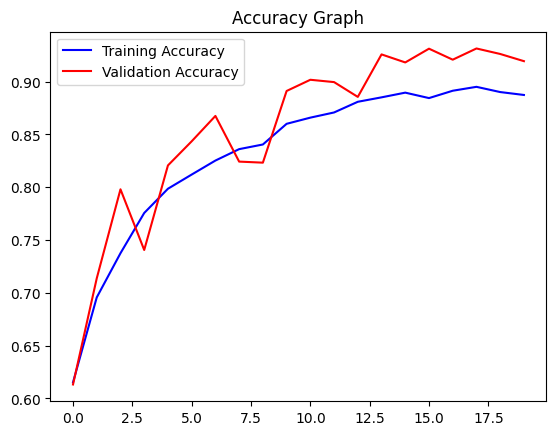

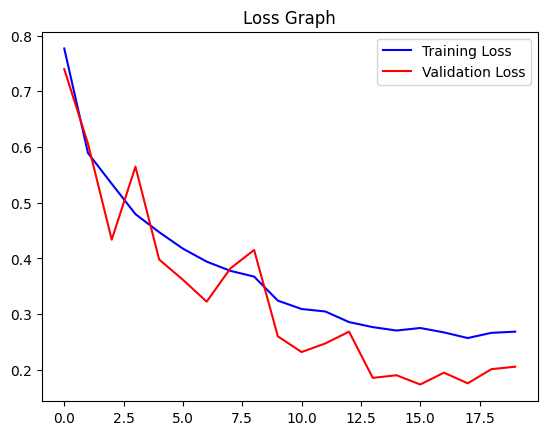

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b',
label='Training Loss')
plt.plot(epochs, val_loss, 'r',
label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


1/1 [==============================] - 0s 20ms/step


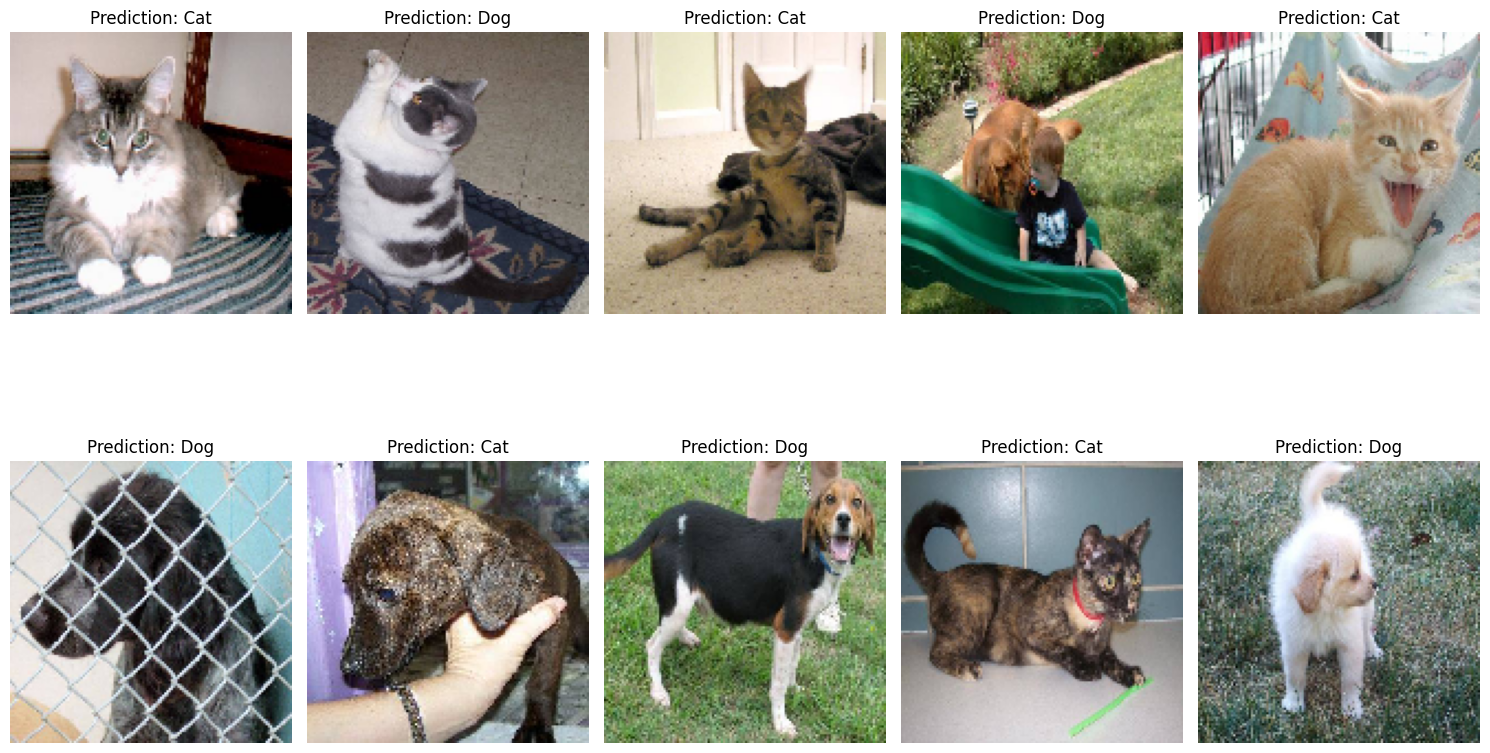

In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Đường dẫn đến thư mục chứa ảnh test
test_dir = '/content/test/test1'

# Lấy danh sách tất cả các file ảnh trong thư mục
all_files = os.listdir(test_dir)

# Chọn ngẫu nhiên 10 ảnh
random_files = random.sample(all_files, 10)

# Hàm để hiển thị ảnh và dự đoán
def display_images_with_predictions(files, model, target_size):
    plt.figure(figsize=(15, 10))

    for i, file in enumerate(files):
        img_path = os.path.join(test_dir, file)

        # Load và chuẩn bị ảnh
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Chuẩn hóa ảnh
        img_array = np.expand_dims(img_array, axis=0)

        # Dự đoán
        prediction = model.predict(img_array)
        if prediction[0][0] > prediction[0][1]:
            label = 'Cat'
        else:
            label = 'Dog'

        # Hiển thị ảnh và dự đoán
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Prediction: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị ảnh và dự đoán
IMAGE_SIZE = (128, 128)  # Kích thước ảnh đã dùng để train model
display_images_with_predictions(random_files, model, IMAGE_SIZE)